# Simulating reviewing with synthetic priors

## Loading packages and importing dataset

In [ ]:
import asreview
import pandas as pd
from asreview.models.balancers import Balanced
from asreview.models.classifiers import SVM
from asreview.models.feature_extractors import Tfidf
from asreview.models.queriers import Max
import numpy as np
import random
import math
from dotenv import load_dotenv
import dspy
from openai import OpenAI
import litellm


In [4]:
dataset = pd.read_csv(r'C:\Users\timov\Desktop\Utrecht\Utrecht\MSBBSS\thesis_timo\Synergy\synergy_dataset\Sep_2021.csv')

## Generating and selecting priors

### Importing research specific stimulus

In [53]:
synergy_metadata = pd.read_excel(r'C:\Users\timov\Desktop\Utrecht\Utrecht\MSBBSS\thesis_timo\Synergy\synergy_dataset_overview.xlsx')

np.where(synergy_metadata['dataset_ID'].to_numpy() == 'Sep_2021')

row_of_dataset = synergy_metadata.index[synergy_metadata['dataset_ID'].eq('Sep_2021')]

int_of_row = int(row_of_dataset[0])

criteria = synergy_metadata.loc[int_of_row, ['inclusion_criteria', 'exclusion_criteria']]

### Generating synthetic priors

load_dotenv()  # Load environment variables from .env file

lm = dspy.LM("openai/gpt-4o-mini", temperature=0.7)
dspy.configure(lm=lm)

class MakeAbstract(dspy.Signature):
    """Generate a fake abstract based on search terms and whether it should be included or not."""
    criteria: str = dspy.InputField(desc="The inclusion or exclusion criteria of the review")
    label_included: int = dspy.InputField(desc="1 if it would perfectly fit the review; 0 if it would be returned by the given search terms but not fit the review")
    #nonce: str = dspy.InputField() 
    jsonl: str = dspy.OutputField(desc='One-line JSON object: {"doi":"None","title":"...","abstract":"...","label_included":"1/0","reasoning":"..."}')

make_abstract = dspy.ChainOfThought(MakeAbstract)

included = make_abstract(
    criteria = criteria['inclusion_criteria'],
    label_included=1,
    #nonce=f"run-{i}",
    extra_instructions=""
).jsonl

#generate excluded abstract
excluded = make_abstract(
    criteria = criteria['exclusion_criteria'],
    label_included=0,
    #nonce=f"run-{i}",
    extra_instructions=""
).jsonl

In [163]:
#Create the first fake row
fake_row_1 = {
    'doi': 'https://doi.org/10.1234/fake.2023.0001',
    'title': 'Fake Study on Something Interesting 1',
    'abstract': 'This study explores something very interesting 1.',
    'label_included': 1,
}

fake_row_2= {
    'doi': 'https://doi.org/10.1234/fake.2023.0002',
    'title': 'Fake Study on Something Interesting 2',
    'abstract': 'This study explores something very interesting 2.',
    'label_included': 0,
}

# # Create a DataFrame for the fake row
fake_row_df = pd.DataFrame([fake_row_1, fake_row_2])

# Concatenate the existing DataFrame with the fake row DataFrame
dataset_llm = pd.concat([dataset, fake_row_df], ignore_index=True)

## Create an array of integers with index of the fake_row_df in dataset_llm
llm_prior_idx = np.array(range(len(dataset), len(dataset_llm)))

# # # save dataset with LLM priors to file with same name as original dataset
# dataset_llm.to_csv(dataset, index=False)
llm_prior_idx + 1

array([272, 273])

### Randomly select one relevant and one irrelevant paper

In [153]:
# take randomly sampled prior index of one relevant and one irrelevant record from original dataset
pos0 = np.where(dataset['label_included'].to_numpy() == 0)[0]
pos1 = np.where(dataset['label_included'].to_numpy() == 1)[0]

if len(pos0) == 0 or len(pos1) == 0:
    raise ValueError("Need at least one row with label_included==0 and one with ==1.")

i0 = int(random.choice(pos0))
i1 = int(random.choice(pos1))

print(f"Using prior indices {i0} (label 0) and {i1} (label 1) from original dataset as minimal priors.")
minimal_prior_idx = [i0, i1]
print(minimal_prior_idx)

Using prior indices 74 (label 0) and 77 (label 1) from original dataset as minimal priors.
[74, 77]


### Randomly 'search for' one relevant and one irrelevant paper

In [307]:
# Optional: set a seed for reproducibility
# random.seed(42)

df = dataset.reset_index(drop=True)  # align iloc with positions 0..n-1
labels = df['label_included']

# Make a pool of positions, shuffle once (no replacement), then check one-by-one
indices = list(range(len(df)))
random.shuffle(indices)

priors = {}        # will hold {0: idx0, 1: idx1}
count = 0          # how many records we've "looked at"

for i in indices:
    count += 1
    lbl = labels.iloc[i]

    lbl = int(lbl)
    if lbl in (0, 1) and lbl not in priors:
        priors[lbl] = i
        # stop as soon as we have one relevant (1) and one irrelevant (0)
        if set(priors) == {0, 1}:
            break

if set(priors) != {0, 1}:
    raise ValueError("Could not find both classes (0 and 1) in the dataset.")

prior_indices = [priors[0], priors[1]]
print("priors:", prior_indices, "| records checked:", count)


priors: [155, 206] | records checked: 7


## Simulation time!

In [348]:
tfidf_kwargs = {
    "ngram_range": (1, 2),
    "sublinear_tf": True,
    "max_df": 0.95,
    "min_df": 1,
}

alc = asreview.ActiveLearningCycle(
    querier=Max(),
    classifier=SVM(C=0.11, loss="squared_hinge"),
    balancer=Balanced(ratio=9.8),
    feature_extractor=Tfidf(**tfidf_kwargs),
)

# Run simulation with minimal priors
simulate_minimal = asreview.Simulate(X=dataset, labels=dataset["label_included"], cycles=[alc])
simulate_minimal.label(minimal_prior_idx)
simulate_minimal.review()

# Run simulation with LLM priors
simulate_llm = asreview.Simulate(X=dataset_llm, labels=dataset_llm["label_included"], cycles=[alc])
simulate_llm.label(llm_prior_idx)
simulate_llm.review()

# Run simulation without priors (random start)
simulate_no_priors = asreview.Simulate(X=dataset, labels=dataset["label_included"], cycles=[alc])
simulate_no_priors.label(prior_indices)
simulate_no_priors.review()

# This line drops priors. To access the dataframe before this, just use simulate._results
df_results_minimal = simulate_minimal._results.dropna(axis=0, subset="training_set")














































































































Records labeled       :  82%|████████▏ | 223/271 [00:01<00:00, 181.35it/s]



Loss: 0.176
NDCG: 0.798





















Records labeled       :  82%|████████▏ | 225/273 [00:01<00:00, 210.30it/s]



Loss: 0.163
NDCG: 0.808




























































































Records labeled       :  82%|████████▏ | 223/271 [00:01<00:00, 180.55it/s]


Loss: 0.171
NDCG: 0.733


In [349]:
simulate_llm._results
#simulate_minimal._results.to_csv(r'C:\Users\timov\Desktop\Utrecht\Utrecht\MSBBSS\thesis_timo\simulations\Output\simulation_results.csv', index=False)

,record_id,label,classifier,querier,balancer,feature_extractor,training_set,time,note,tags,user_id
0,271,1,None,None,None,None,None,1.760633e+09,None,None,None
1,272,0,None,None,None,None,None,1.760633e+09,None,None,None
2,206,1,svm,max,balanced,tfidf,2,1.760633e+09,None,None,None
3,270,0,svm,max,balanced,tfidf,3,1.760633e+09,None,None,None
4,243,0,svm,max,balanced,tfidf,4,1.760633e+09,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
220,220,0,svm,max,balanced,tfidf,220,1.760633e+09,None,None,None
221,141,0,svm,max,balanced,tfidf,221,1.760633e+09,None,None,None
222,57,0,svm,max,balanced,tfidf,222,1.760633e+09,None,None,None
223,202,0,svm,max,balanced,tfidf,223,1.760633e+09,None,None,None


In [350]:
#remove first two labels which are synthetic priors
simulate_llm._results = simulate_llm._results.iloc[len(llm_prior_idx):]


In [353]:
def pad_labels_minimal(labels, num_priors, num_records):
    return pd.Series(
        labels.tolist() + np.zeros(num_records - len(labels) - num_priors).tolist()
    )

def pad_labels_llm(labels, num_priors, num_records):
    return pd.Series(
        labels.tolist() + np.zeros(num_records - len(labels) - 2*num_priors).tolist()
    )


# function for adding zeros before the point where the simulations starts (based on number of samples needed to find at least one relevant and one irrelevant record )
def pad_labels_random_search(labels, count, num_priors, num_records):
    return pd.Series(
        np.zeros(count - num_priors).tolist() + labels.tolist() + np.zeros(num_records - len(labels) - count).tolist()
    )

In [354]:
# concatenate the three cumulative sum results in one dataframe for adding metadata and plotting

df_cumsum = pd.DataFrame({
    'Minimal Priors': pad_labels_minimal(simulate_minimal._results["label"].reset_index(drop=True), len(minimal_prior_idx), len(dataset)).cumsum(),
    'LLM Priors': pad_labels_llm(simulate_llm._results["label"].reset_index(drop=True), len(llm_prior_idx), len(dataset_llm)).cumsum(),
    'No Priors': pad_labels_random_search(simulate_no_priors._results["label"].reset_index(drop=True), count, len(prior_indices), len(dataset)).cumsum()
})

df_cumsum

,Minimal Priors,LLM Priors,No Priors
0,0.0,1.0,0.0
1,1.0,1.0,0.0
2,2.0,1.0,0.0
3,2.0,2.0,0.0
4,3.0,3.0,0.0
...,...,...,...
264,40.0,40.0,40.0
265,40.0,40.0,40.0
266,40.0,40.0,40.0
267,40.0,40.0,40.0


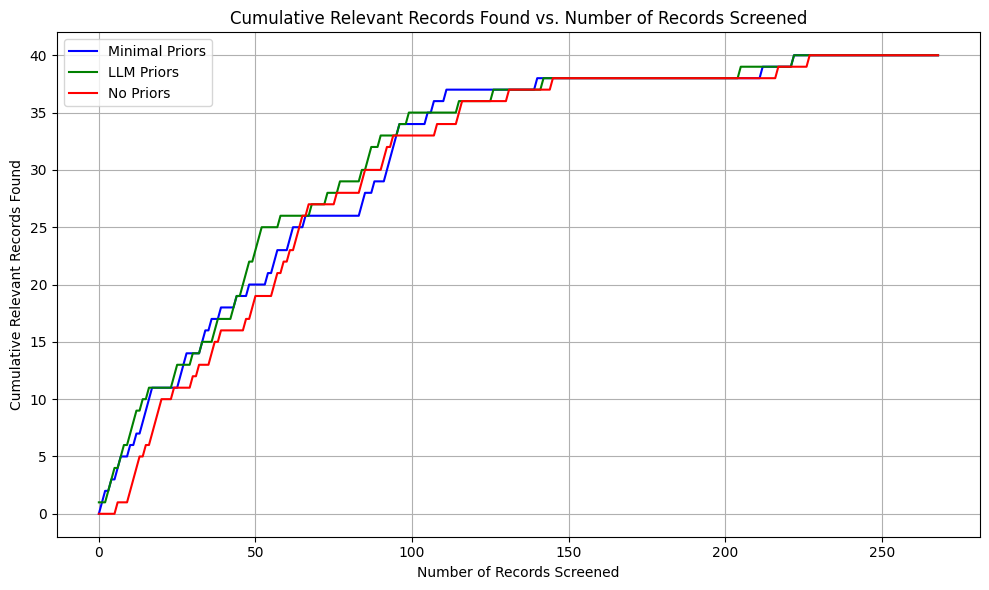

In [356]:
# generate a plot with cumulative sum of relevant records found over number of records screened for the three strategies
import matplotlib.pyplot as plt
# --- IGNORE ---
plt.figure(figsize=(10, 6))
plt.plot(df_cumsum['Minimal Priors'], label='Minimal Priors', color='blue')
plt.plot(df_cumsum['LLM Priors'], label='LLM Priors', color='green')
plt.plot(df_cumsum['No Priors'], label='No Priors', color='red')
plt.xlabel('Number of Records Screened')
plt.ylabel('Cumulative Relevant Records Found')
plt.title('Cumulative Relevant Records Found vs. Number of Records Screened')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [ ]:
pad_labels(simulate_minimal._results["label"].reset_index(drop=True), len(minimal_prior_idx), len(dataset)).cumsum().plot()

0       0.0
1       1.0
2       2.0
3       2.0
4       3.0
       ... 
264    40.0
265    40.0
266    40.0
267    40.0
268    40.0
Length: 269, dtype: float64

<Axes: >

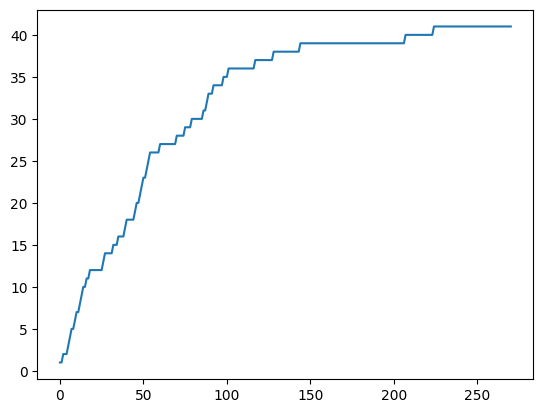

In [284]:
pad_labels(simulate_llm._results["label"].reset_index(drop=True), len(llm_prior_idx), len(dataset_llm)).cumsum().plot()

<Axes: >

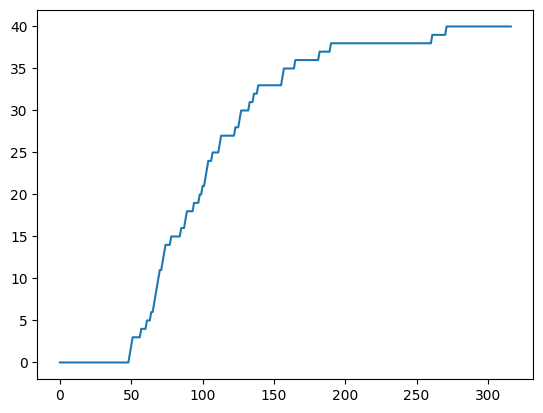

In [285]:
pad_labels_before_start(simulate_no_priors._results["label"].reset_index(drop=True), count, len(prior_indices), len(dataset)).cumsum().plot()

In [ ]:
#dataset_llm.to_csv(r'C:\Users\timov\Desktop\Utrecht\Utrecht\MSBBSS\thesis_timo\simulations\Output\dataset_llm.csv', index=False)
dataset_llm.iloc[prior_indices]

,doi,title,abstract,label_included
138,https://doi.org/10.1097/eja.0b013e3283534f56,Meloxicam improves object recognition memory a...,Surgery-induced neuroinflammation has been imp...,0
66,https://doi.org/10.1016/j.ejphar.2010.10.074,Persisting cognitive deficits induced by low-d...,Cognitive impairments have been proposed as a ...,1
